In [1]:
import json 
import re
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np 
import pandas as pd
import pathlib 

from calibration_metric import ECEMetric
from calibration_metric.vis.calibration_plot import plot_df
from calibration_utils import get_accs_sql, read_benchclamp_file, get_probs_and_accs_benchclamp

/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def horizontal_plot(min_probs, accs, path, bclamp_data, gold_path, n_bins = 10, binning_strategy='uniform', title=None):
    ece_metric = ECEMetric(n_bins=n_bins, binning_strategy=binning_strategy)
    if binning_strategy == "uniform":
        (min_values_em, 
        min_bins, 
        min_bin_number) = ece_metric.uniform_bin(min_probs, accs)
    else:
        (min_values_em, 
        min_bins, 
        min_bin_number) = ece_metric.adaptive_bin(min_probs, accs)

    # convert exact match accuracy to evaluation accuracy
    print(f"getting sql execution accuracy for each bin")
    min_execution_accs = get_accs_sql(bclamp_data, gold_path, min_bin_number, min_bins) 
    print(f"replacing exact match accuracy with execution accuracy...")
    min_values_ev = [min_execution_accs[bin] for bin in range(len(min_values_em))]
    lines_to_plot = []
    for before_x, before_y, after_x in zip(min_values_em, min_bins, min_values_ev):
        # assert(before_x <= after_x)
        print(f"{before_x:.3f} -> {after_x:.3f}")
        lines_to_plot.append(((before_x, before_y), (after_x, before_y)))
    # replace the accuracies with copies of the average for computing the ECE on the eval match accuracy

    min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)
    min_df_to_plot_ev = ece_metric.bins_to_df(min_values_ev, min_bins, min_bin_number)

    fig, ax = plt.subplots(1,1, figsize=(4.5,4.5), sharex=True, sharey=True)
    metric_kwargs = {"x": 0.000, "y": 0.9, "fontsize": 10, "horizontalalignment": "left"}

    ax.set_title("Min. Prob.", fontsize=10)
    ax.set_title("Mean Prob.", fontsize=10)
    plot = plot_df(min_df_to_plot_em, 
                   ylabel="Model Prob.", 
                   xlabel=None, 
                   ax = ax, 
                   show_legend=False)
    # overlay onto same plot
    plot = plot_df(min_df_to_plot_ev, 
                   ylabel="Model Prob.", 
                   xlabel=None, 
                   ax = ax, 
                   show_legend=False)
    ax.set_xlabel("Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})

    # plot connecting lines
    for line in lines_to_plot:
        (x1, y1), (x2, y2) = line
        ax.plot([x1, x2], [y1, y2], color='black', linewidth=0.5, linestyle='--')

    # handles, labels = plt.gca().get_legend_handles_labels()
    # fig.legend(handles, labels, fontsize=8, ncol=2, title="Log Count", frameon=False, bbox_to_anchor=(0.53, 0.71), handletextpad=0.1, columnspacing=0.1)
    if title is not None:
        ax.set_title(title, fontsize=14)

    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    # return min_values, min_bins, min_bin_number


bart-large
7 7
ax is None
t5-small
10 10
ax is None
t5-base
8 8
ax is None
t5-large
7 7
ax is None
bart-base
9 9
ax is None
bart-large
7 7
ax is None
codet5-base
7 7
ax is None


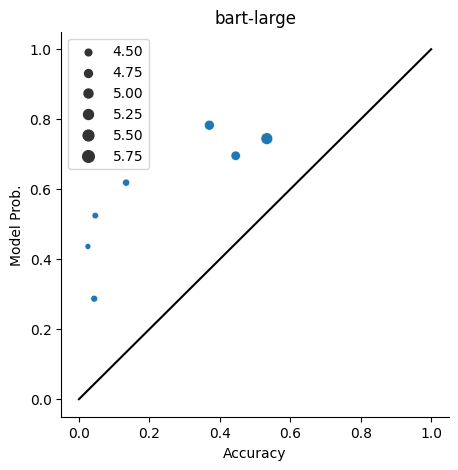

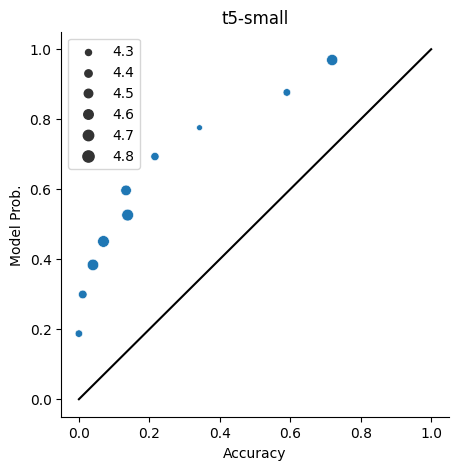

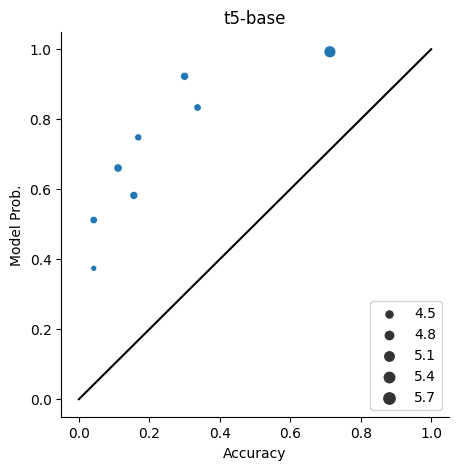

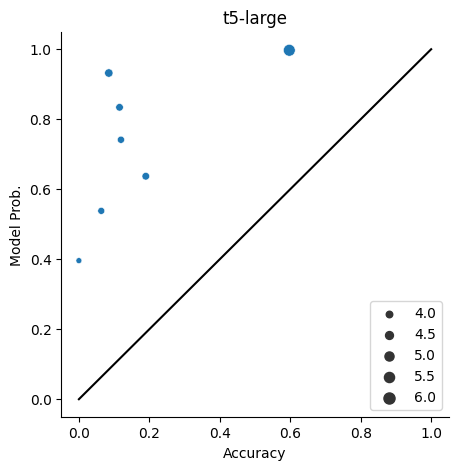

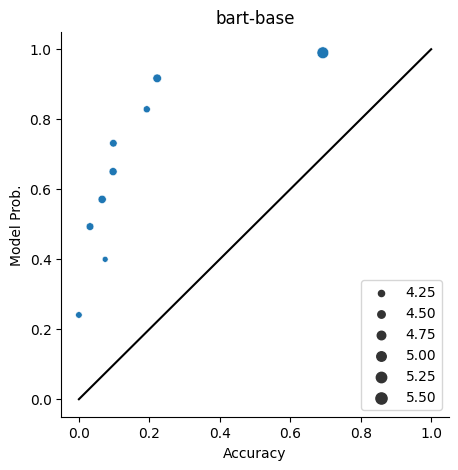

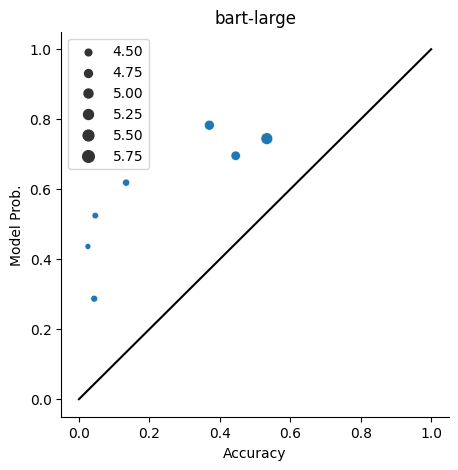

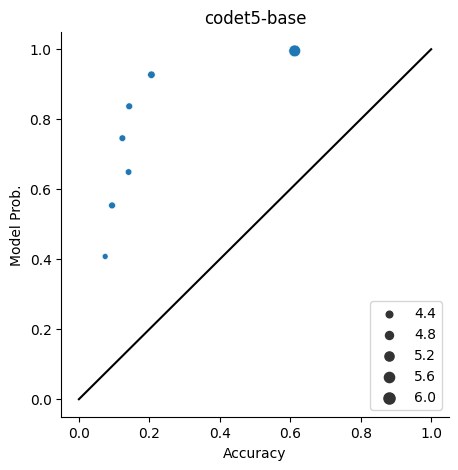

In [3]:


paths = ["/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-small-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230203T092044.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230206T093954.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-large-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T064137.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-base_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T060905.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/codet5-base_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T214405.jsonl"]

spider_gold_path = "/brtx/601-nvme1/estengel/resources/data/benchclamp/processed/Spider/test_all.jsonl"
spider_all_dfs = []
for path in paths: 
    bart_data = read_benchclamp_file(path)
    path = pathlib.Path(path)
    model_name = path.parent.name.split("_")[0]
    model_name = re.sub("-lm-adapt", "", model_name) 
    bart_min_probs, bart_mean_probs, bart_exact_accs = get_probs_and_accs_benchclamp(bart_data) # , spider_gold_path) 

    ece_metric = ECEMetric(n_bins=20, binning_strategy="adaptive")

    (min_values_em, 
    min_bins, 
    min_bin_number) = ece_metric.adaptive_bin(bart_min_probs, bart_exact_accs)

    min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)
    min_df_to_plot_em["model"] = model_name

    source_ppl_data = json.load(open(f"spider_test_by_{model_name}_bin/conf_and_ppl_source.json"))
    target_ppl_data = json.load(open(f"spider_test_by_{model_name}_bin/conf_and_ppl_target.json"))

    print(model_name)
    print(len(source_ppl_data), len(min_df_to_plot_em))
    # sort by confidence, decreasing
    target_ppl_data = sorted(target_ppl_data, key=lambda x: x[0], reverse=True)
    source_ppl_data = sorted(source_ppl_data, key=lambda x: x[0], reverse=True)
    # add source data to df 
    min_df_to_plot_em['target_ppl'] = [x[1] for x in target_ppl_data]
    min_df_to_plot_em['source_ppl'] = [x[1] for x in source_ppl_data]
    spider_all_dfs.append(min_df_to_plot_em)

    # plot
    plot_df(min_df_to_plot_em, title=model_name)
    # horizontal_plot(bart_min_probs, bart_exact_accs, path=None,
    #                 bclamp_data=bart_data, gold_path = spider_gold_path,
    #                 binning_strategy="adaptive", title=model_name)


In [4]:
# concat all dfs 
spider_all_dfs = pd.concat(spider_all_dfs)

In [5]:
# ece is absolute difference between model and correct

# min_df_to_plot_em['bin_ece'] = min_df_to_plot_em['prob_model'] - min_df_to_plot_em['prob_correct']
# min_df_to_plot_em['bin_ece'] = min_df_to_plot_em['bin_ece'].abs()
spider_all_dfs['bin_ece'] = spider_all_dfs['prob_model'] - spider_all_dfs['prob_correct']
spider_all_dfs['bin_ece'] = spider_all_dfs['bin_ece'].abs()

## Is perplexity correlated with calibration error?
We can get the calibration error for each bin, and the average perplexity for that bin, and see if they are correlated.
We can look both at source and target perplexity. 

target_p_value: 0.8707402137649779
source_p_value: 0.000685305906395043
bart-large target_p_value: 0.3734637684143586
t5-small target_p_value: 0.7253405917789713
t5-base target_p_value: 0.468403689196619
t5-large target_p_value: 0.9854779989820306
bart-base target_p_value: 0.41441581816855344
codet5-base target_p_value: 0.9732928314283193
bart-large source_p_value: 0.0003444897481284266
t5-small source_p_value: 0.8523139345092005
t5-base source_p_value: 0.37515175019204094
t5-large source_p_value: 0.15429173365856577
bart-base source_p_value: 0.8873140414773727
codet5-base source_p_value: 0.04015309363509442


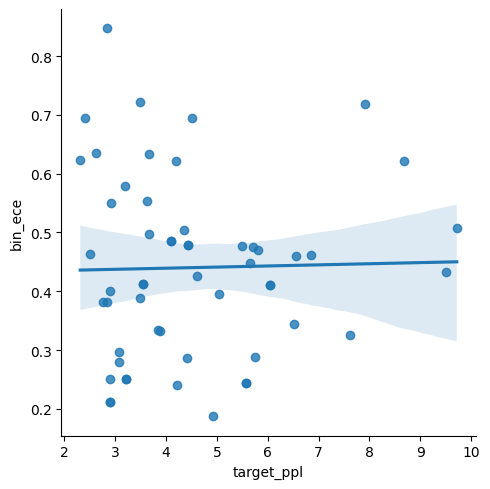

<Figure size 640x480 with 0 Axes>

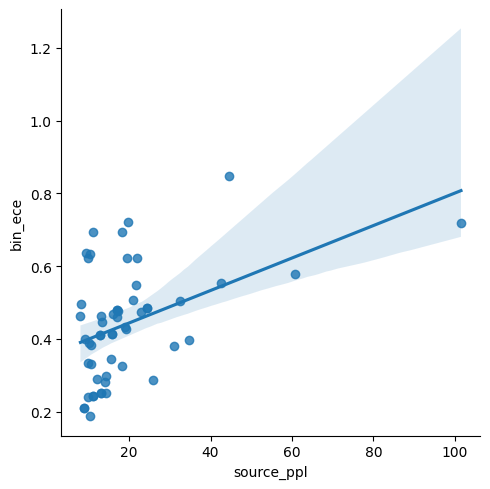

<Figure size 640x480 with 0 Axes>

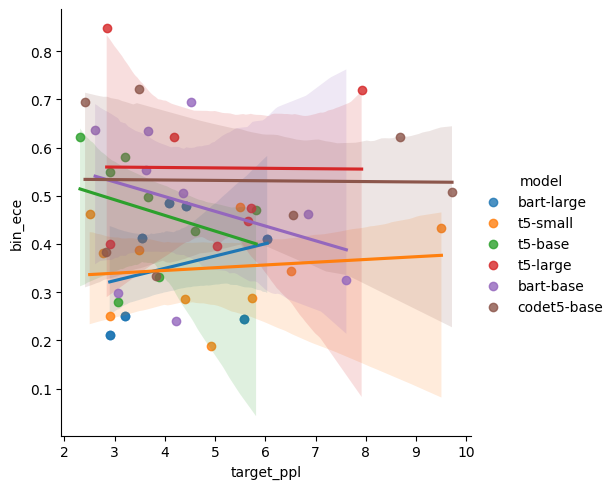

<Figure size 640x480 with 0 Axes>

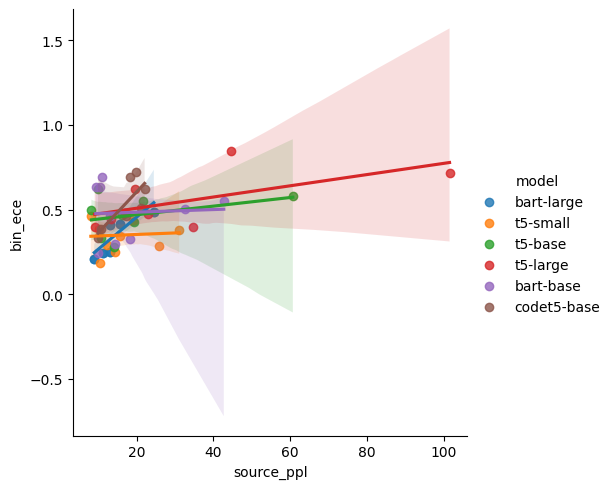

In [6]:

from scipy import stats

target_slope, target_intercept, target_r_value, target_p_value, target_std_err = stats.linregress(spider_all_dfs['target_ppl'], spider_all_dfs['bin_ece'])
print(f"target_p_value: {target_p_value}")
# sns.lmplot(data= all_dfs, x='target_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(target_slope,target_intercept)})
sns.lmplot(data=spider_all_dfs, x='target_ppl', y='bin_ece', scatter=True)
plt.figure()
source_slope, source_intercept, source_r_value, source_p_value, source_std_err = stats.linregress(spider_all_dfs['source_ppl'], spider_all_dfs['bin_ece'])
print(f"source_p_value: {source_p_value}")
# sns.lmplot(data= all_dfs, x='source_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(source_slope,source_intercept)})
sns.lmplot(data=spider_all_dfs, x='source_ppl', y='bin_ece', scatter=True)
plt.figure()

for model in spider_all_dfs['model'].unique():
    df = spider_all_dfs[spider_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['target_ppl'], df['bin_ece'])
    print(f"{model} target_p_value: {p_value}")
# #     sns.lmplot(data= df, x='target_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
# #     plt.title(f"{model} p_value: {p_value:.3f}")
# # plt.figure()
for model in spider_all_dfs['model'].unique():
    df = spider_all_dfs[spider_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['source_ppl'], df['bin_ece'])
    print(f"{model} source_p_value: {p_value}")
#     sns.lmplot(data= df, x='source_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
#     plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure() 

sns.lmplot(data=spider_all_dfs, x='target_ppl', y='bin_ece', scatter=True, hue="model")
plt.figure()
sns.lmplot(data=spider_all_dfs, x='source_ppl', y='bin_ece', scatter=True, hue="model")

## Answer: Only with source perplexity 
On average (across all models), calibration error is correlated with perplexity of the input, but not perplexity of the output. 

## Is perplexity correlated with confidence?

target_p_value: 0.008169521204917153
source_p_value: 0.31258229358379236
bart-large target_p_value: 1.0893712465991581e-05
t5-small target_p_value: 0.9079341947113013
t5-base target_p_value: 0.08358104771586981
t5-large target_p_value: 0.3772165271197157
bart-base target_p_value: 0.10300237209719303
codet5-base target_p_value: 0.4130831556825737
bart-large source_p_value: 0.7015460149298122
t5-small source_p_value: 0.44153345417295087
t5-base source_p_value: 0.9857430628872839
t5-large source_p_value: 0.7479507382233083
bart-base source_p_value: 0.7921560906968121
codet5-base source_p_value: 0.7244426782799442


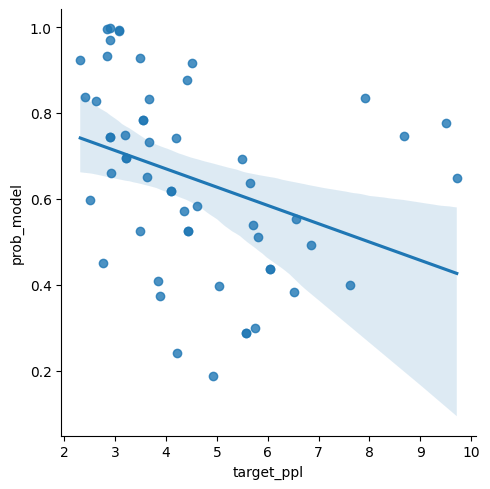

<Figure size 640x480 with 0 Axes>

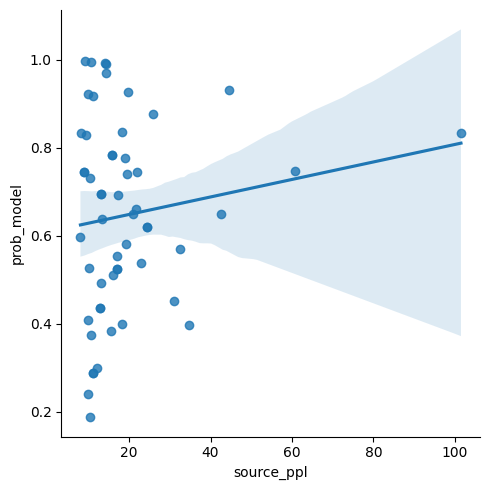

<Figure size 640x480 with 0 Axes>

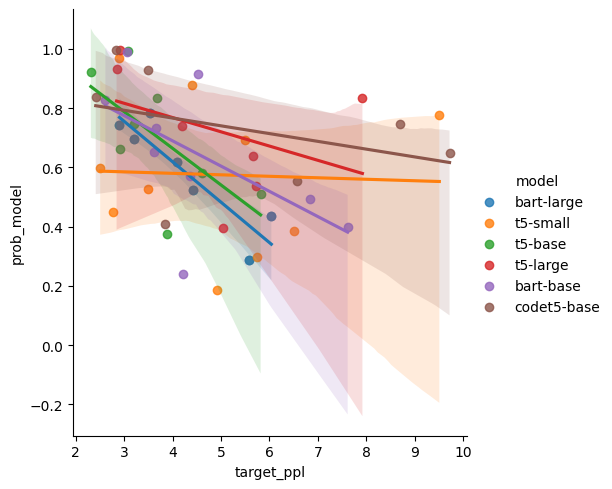

<Figure size 640x480 with 0 Axes>

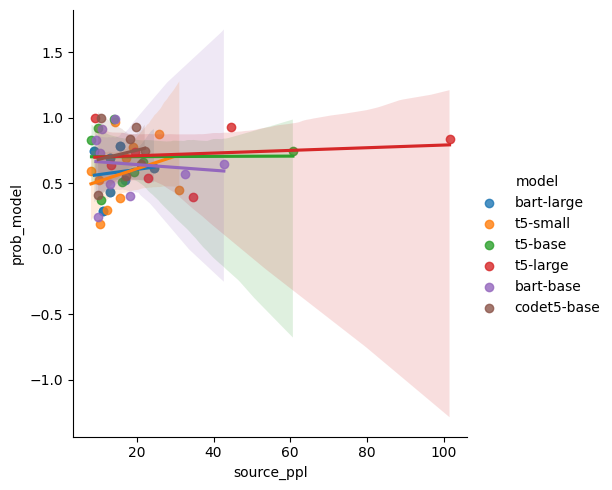

In [7]:

from scipy import stats

target_slope, target_intercept, target_r_value, target_p_value, target_std_err = stats.linregress(spider_all_dfs['target_ppl'], spider_all_dfs['prob_model'])
print(f"target_p_value: {target_p_value}")
sns.lmplot(data=spider_all_dfs, x='target_ppl', y='prob_model', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(target_slope,target_intercept)})
plt.figure()
source_slope, source_intercept, source_r_value, source_p_value, source_std_err = stats.linregress(spider_all_dfs['source_ppl'], spider_all_dfs['prob_model'])
print(f"source_p_value: {source_p_value}")
sns.lmplot(data= spider_all_dfs, x='source_ppl', y='prob_model', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(source_slope,source_intercept)})
plt.figure()

for model in spider_all_dfs['model'].unique():
    df = spider_all_dfs[spider_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['target_ppl'], df['prob_model'])
    print(f"{model} target_p_value: {p_value}")
    # sns.lmplot(data= df, x='target_ppl', y='prob_model', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    # plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure()
for model in spider_all_dfs['model'].unique():
    df = spider_all_dfs[spider_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['source_ppl'], df['prob_model'])
    print(f"{model} source_p_value: {p_value}")
    # sns.lmplot(data= df, x='source_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    # plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure() 

sns.lmplot(data=spider_all_dfs, x='target_ppl', y='prob_model', scatter=True, hue="model")
plt.figure()
sns.lmplot(data=spider_all_dfs, x='source_ppl', y='prob_model', scatter=True, hue="model")

## Answer: maybe?
On average, perplexity is negatively correlated with confidence (but only for target this time). The higher the target perplexity, the lower the model confidence. 

This is not necessarily in conflict with target perplexity not being correlated with error, since error is difference between confidence and accuracy. 

## Is perplexity correlated with accuracy? 

target_p_value: 0.0035555574487437613
source_p_value: 0.18649036699539215
bart-large target_p_value: 1.935587269305055e-05
t5-small target_p_value: 0.8008239802876493
t5-base target_p_value: 0.25823888312720444
t5-large target_p_value: 0.341436336193175
bart-base target_p_value: 0.24255838414487188
codet5-base target_p_value: 0.3718609588510947
bart-large source_p_value: 0.31662012409582657
t5-small source_p_value: 0.31662012409582657
t5-base source_p_value: 0.31662012409582657
t5-large source_p_value: 0.31662012409582657
bart-base source_p_value: 0.31662012409582657
codet5-base source_p_value: 0.31662012409582657


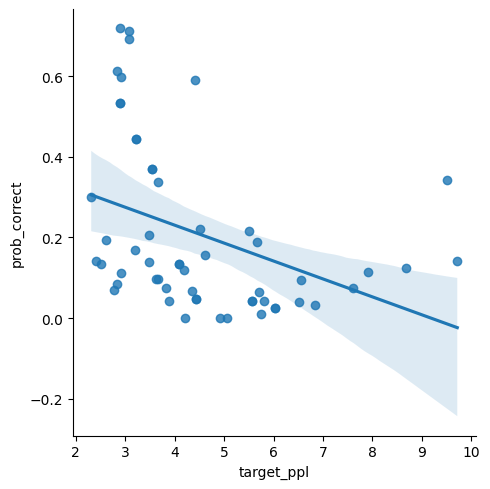

<Figure size 640x480 with 0 Axes>

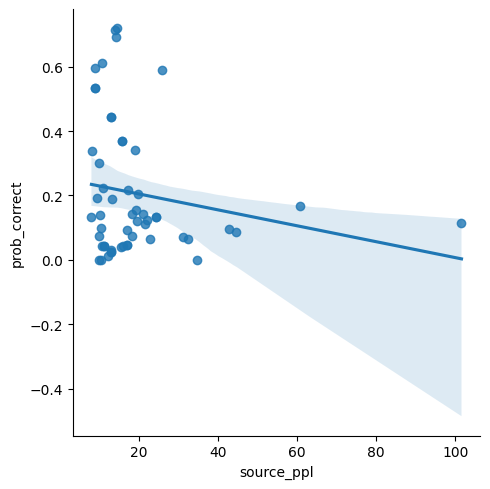

<Figure size 640x480 with 0 Axes>

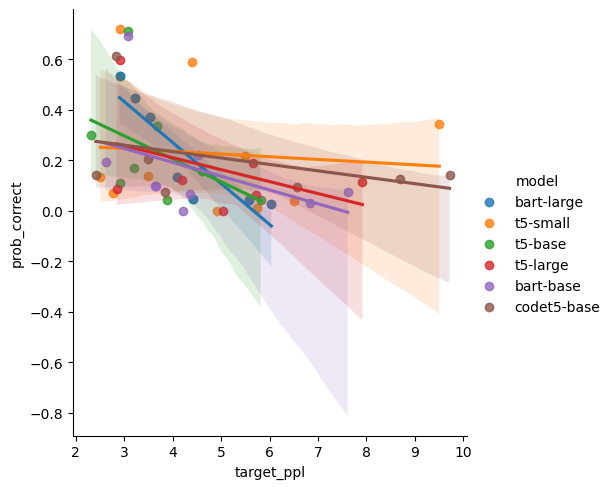

<Figure size 640x480 with 0 Axes>

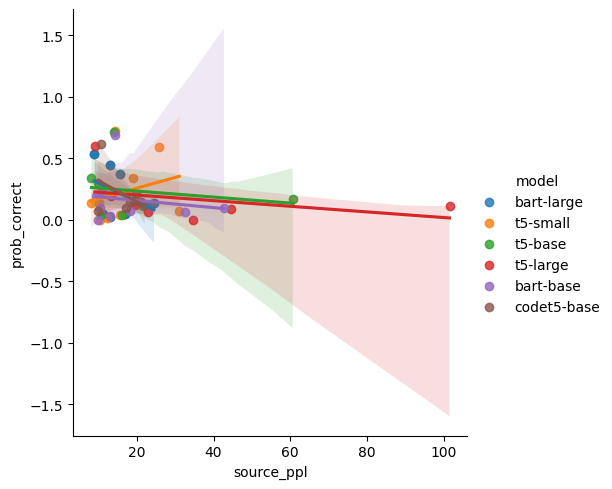

In [8]:

from scipy import stats

target_slope, target_intercept, target_r_value, target_p_value, target_std_err = stats.linregress(spider_all_dfs['target_ppl'], spider_all_dfs['prob_correct'])
print(f"target_p_value: {target_p_value}")
sns.lmplot(data=spider_all_dfs, x='target_ppl', y='prob_correct', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(target_slope,target_intercept)})
plt.figure()
source_slope, source_intercept, source_r_value, source_p_value, source_std_err = stats.linregress(spider_all_dfs['source_ppl'], spider_all_dfs['prob_correct'])
print(f"source_p_value: {source_p_value}")
sns.lmplot(data=spider_all_dfs, x='source_ppl', y='prob_correct', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(source_slope,source_intercept)})
plt.figure()

for model in spider_all_dfs['model'].unique():
    df = spider_all_dfs[spider_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['target_ppl'], df['prob_correct'])
    print(f"{model} target_p_value: {p_value}")
    # sns.lmplot(data= df, x='target_ppl', y='prob_correct', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    # plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure()
for model in spider_all_dfs['model'].unique():
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['source_ppl'], df['prob_correct'])
    print(f"{model} source_p_value: {p_value}")
    # sns.lmplot(data= df, x='source_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    # plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure() 

sns.lmplot(data=spider_all_dfs, x='target_ppl', y='prob_correct', scatter=True, hue="model")
plt.figure()
sns.lmplot(data=spider_all_dfs, x='source_ppl', y='prob_correct', scatter=True, hue="model")

## Answer: Yes for target

Target ppl is negatively correlated with bin accuracy when when averaged across the models. The higher the ppl, the lower the accuracy.
Source PPL is not significantly correlated. 

This is confusing. How can ppl be correlated to the error (Acc. - Conf.) if it's not correlated to Acc. or Conf?

## What about for Calflow?

t5-small
24 24
ax is None
t5-base
20 20
ax is None
t5-large
18 18
ax is None
bart-base
17 17
ax is None
bart-large
16 16
ax is None


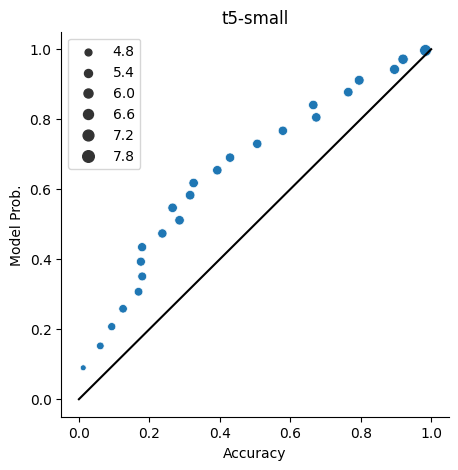

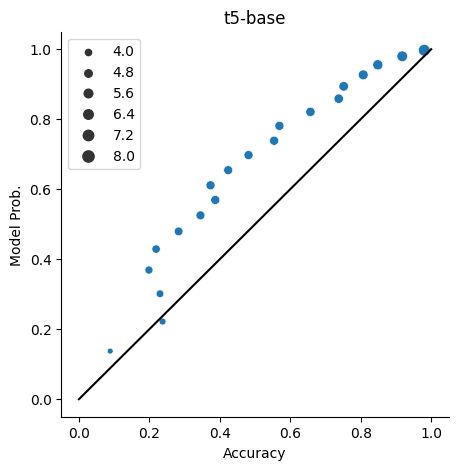

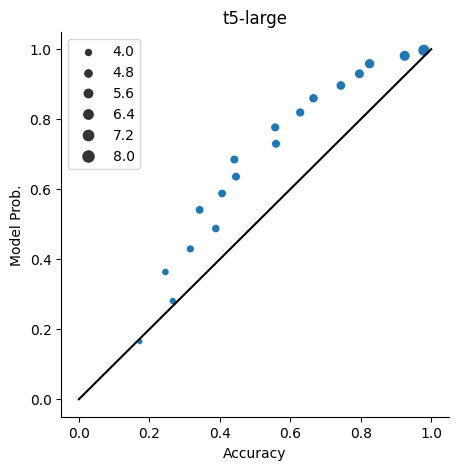

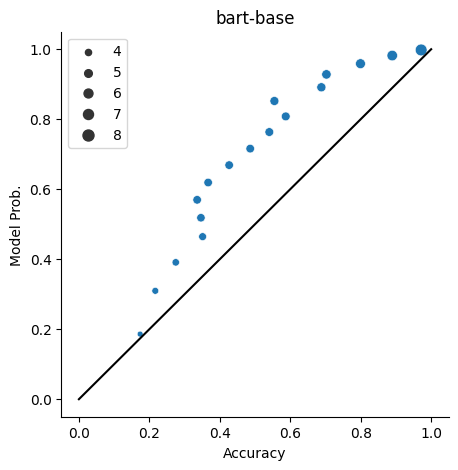

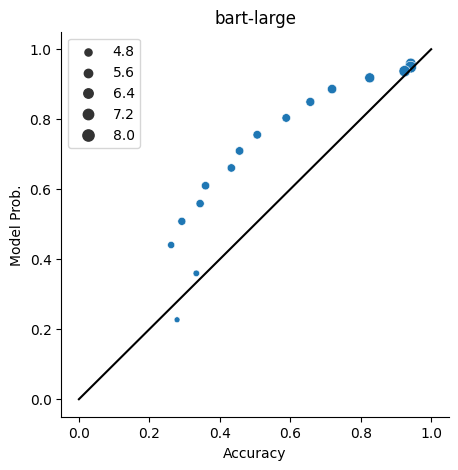

In [9]:


paths = ["/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-small-lm-adapt_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230223T160146.jsonl", # t5_small
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-base-lm-adapt_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230223T135433.jsonl", # t5_base
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-large-lm-adapt_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20221102T103315.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-base_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230222T155549.jsonl", # bart_base
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20221101T105421.jsonl", # bart_large
        ]

calflow_gold_path = "/brtx/601-nvme1/estengel/resources/data/benchclamp/processed/CalFlowV2/test_all.jsonl"
calflow_all_dfs = []
for path in paths: 
    if path == "":
        continue

    bart_data = read_benchclamp_file(path)
    path = pathlib.Path(path)
    model_name = path.parent.name.split("_")[0]
    model_name = re.sub("-lm-adapt", "", model_name) 
    bart_min_probs, bart_mean_probs, bart_exact_accs = get_probs_and_accs_benchclamp(bart_data) # , spider_gold_path) 

    ece_metric = ECEMetric(n_bins=20, binning_strategy="adaptive")

    (min_values_em, 
    min_bins, 
    min_bin_number) = ece_metric.adaptive_bin(bart_min_probs, bart_exact_accs)

    min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)
    min_df_to_plot_em["model"] = model_name

    source_ppl_data = json.load(open(f"calflow_test_by_{model_name}_bin/conf_and_ppl_source.json"))
    target_ppl_data = json.load(open(f"calflow_test_by_{model_name}_bin/conf_and_ppl_target.json"))

    print(model_name)
    print(len(source_ppl_data), len(min_df_to_plot_em))
    # sort by confidence, decreasing
    source_ppl_data = sorted(source_ppl_data, key=lambda x: x[0], reverse=True)
    target_ppl_data = sorted(target_ppl_data, key=lambda x: x[0], reverse=True)
    # add source data to df 
    min_df_to_plot_em['source_ppl'] = [x[1] for x in source_ppl_data]
    min_df_to_plot_em['target_ppl'] = [x[1] for x in target_ppl_data]
    calflow_all_dfs.append(min_df_to_plot_em)

    # plot
    plot_df(min_df_to_plot_em, title=model_name)
    # horizontal_plot(bart_min_probs, bart_exact_accs, path=None,
    #                 bclamp_data=bart_data, gold_path = spider_gold_path,
    #                 binning_strategy="adaptive", title=model_name)


In [10]:
# concat all dfs 
calflow_all_dfs = pd.concat(calflow_all_dfs)

# ece is absolute difference between model and correct
calflow_all_dfs['bin_ece'] = calflow_all_dfs['prob_model'] - calflow_all_dfs['prob_correct']
calflow_all_dfs['bin_ece'] = calflow_all_dfs['bin_ece'].abs()

target_p_value: 0.07362136925946075
source_p_value: 0.3287286336281309
t5-small target_p_value: 0.6594014950551452
t5-base target_p_value: 0.11495280017055709
t5-large target_p_value: 0.26202497469157615
bart-base target_p_value: 0.04609043486973644
bart-large target_p_value: 0.5046075216385864
t5-small source_p_value: 0.10749079668577534
t5-base source_p_value: 0.48272116584761926
t5-large source_p_value: 0.2240336335938744
bart-base source_p_value: 0.5905082463673772
bart-large source_p_value: 0.12349543184762514


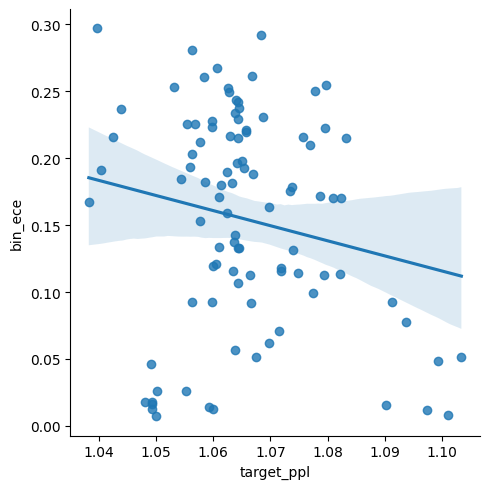

<Figure size 640x480 with 0 Axes>

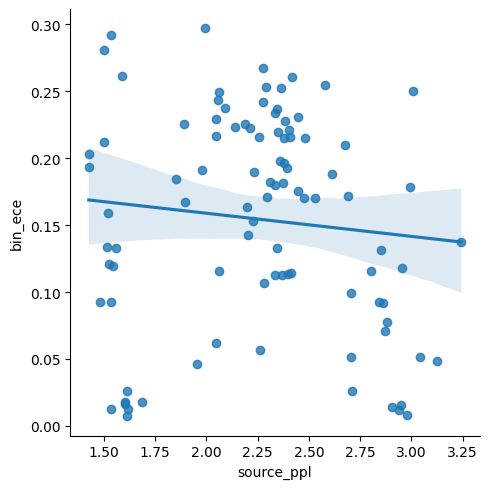

<Figure size 640x480 with 0 Axes>

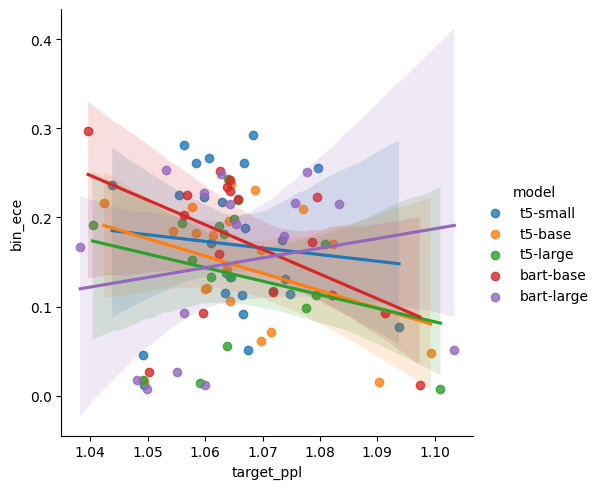

<Figure size 640x480 with 0 Axes>

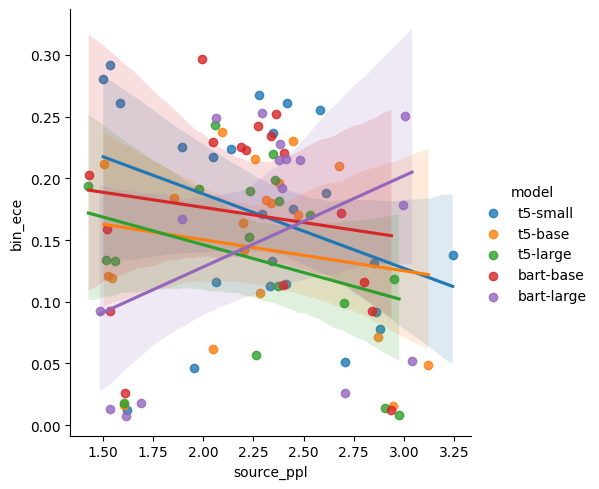

In [11]:

from scipy import stats

target_slope, target_intercept, target_r_value, target_p_value, target_std_err = stats.linregress(calflow_all_dfs['target_ppl'], calflow_all_dfs['bin_ece'])
print(f"target_p_value: {target_p_value}")
sns.lmplot(data=calflow_all_dfs, x='target_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(target_slope,target_intercept)})
plt.figure()
source_slope, source_intercept, source_r_value, source_p_value, source_std_err = stats.linregress(calflow_all_dfs['source_ppl'], calflow_all_dfs['bin_ece'])
print(f"source_p_value: {source_p_value}")
sns.lmplot(data=calflow_all_dfs, x='source_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(source_slope,source_intercept)})
plt.figure()

for model in calflow_all_dfs['model'].unique():
    df = calflow_all_dfs[calflow_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['target_ppl'], df['bin_ece'])
    print(f"{model} target_p_value: {p_value}")
#     sns.lmplot(data= df, x='target_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
#     plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure()
for model in calflow_all_dfs['model'].unique():
    df = calflow_all_dfs[calflow_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['source_ppl'], df['bin_ece'])
    print(f"{model} source_p_value: {p_value}")
#     sns.lmplot(data= df, x='source_ppl', y='bin_ece', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
#     plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure() 

sns.lmplot(data=calflow_all_dfs, x='target_ppl', y='bin_ece', scatter=True, hue="model")
plt.figure()
sns.lmplot(data=calflow_all_dfs, x='source_ppl', y='bin_ece', scatter=True, hue="model")

target_p_value: 2.0807898482565496e-10
source_p_value: 1.227644874286004e-15
t5-small target_p_value: 0.08762569650814894
t5-base target_p_value: 0.0007010042342524739
t5-large target_p_value: 0.00480026170944979
bart-base target_p_value: 5.9731954522232415e-05
bart-large target_p_value: 0.007575128995324217
t5-small source_p_value: 0.1090156321106496
t5-base source_p_value: 6.295835815113215e-06
t5-large source_p_value: 1.7019219073197084e-05
bart-base source_p_value: 1.339475958579364e-06
bart-large source_p_value: 2.76718689578925e-05


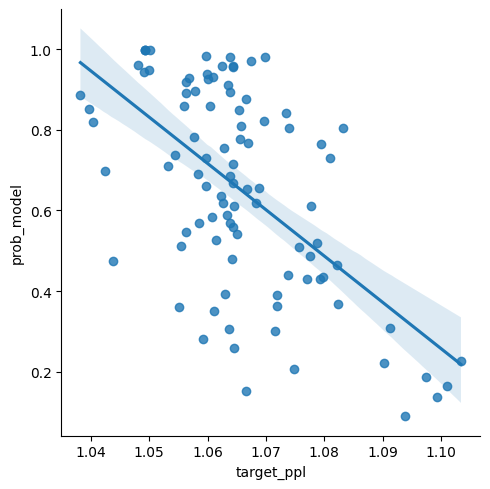

<Figure size 640x480 with 0 Axes>

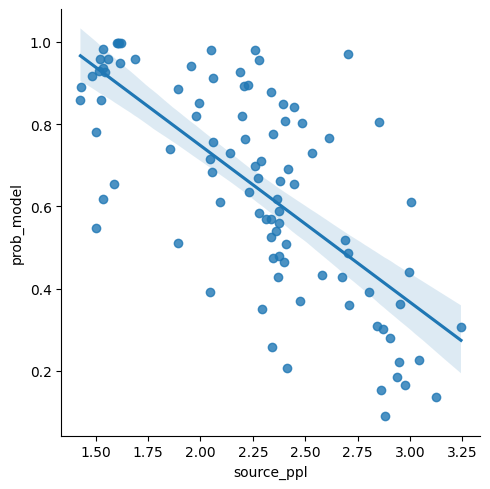

<Figure size 640x480 with 0 Axes>

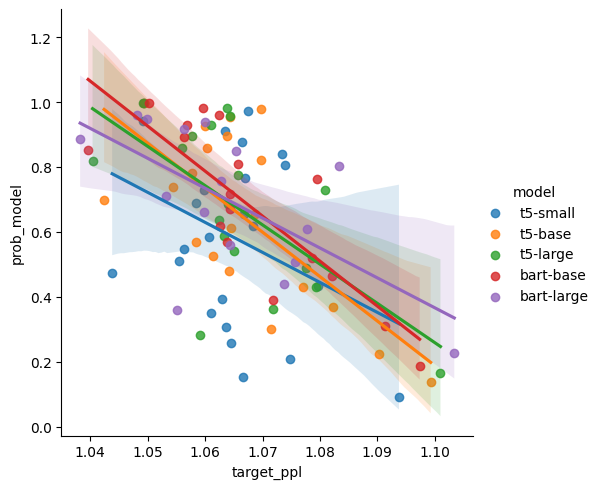

<Figure size 640x480 with 0 Axes>

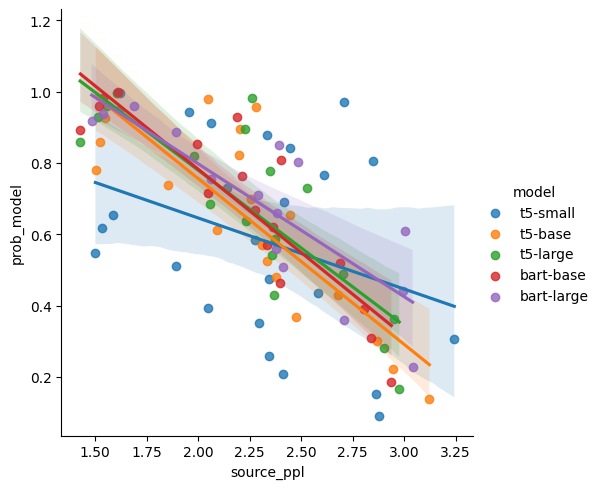

In [12]:

from scipy import stats

target_slope, target_intercept, target_r_value, target_p_value, target_std_err = stats.linregress(calflow_all_dfs['target_ppl'], calflow_all_dfs['prob_model'])
print(f"target_p_value: {target_p_value}")
sns.lmplot(data=calflow_all_dfs, x='target_ppl', y='prob_model', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(target_slope,target_intercept)})
plt.figure()
source_slope, source_intercept, source_r_value, source_p_value, source_std_err = stats.linregress(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_model'])
print(f"source_p_value: {source_p_value}")
sns.lmplot(data=calflow_all_dfs, x='source_ppl', y='prob_model', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(source_slope,source_intercept)})
plt.figure()

for model in calflow_all_dfs['model'].unique():
    df = calflow_all_dfs[calflow_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['target_ppl'], df['prob_model'])
    print(f"{model} target_p_value: {p_value}")
#     sns.lmplot(data= df, x='target_ppl', y='prob_model', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
#     plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure()
for model in calflow_all_dfs['model'].unique():
    df = calflow_all_dfs[calflow_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['source_ppl'], df['prob_model'])
    print(f"{model} source_p_value: {p_value}")
#     sns.lmplot(data= df, x='source_ppl', y='prob_model', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
#     plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure() 

sns.lmplot(data=calflow_all_dfs, x='target_ppl', y='prob_model', scatter=True, hue="model")
plt.figure()
sns.lmplot(data=calflow_all_dfs, x='source_ppl', y='prob_model', scatter=True, hue="model")

target_p_value: 2.1370065576289175e-07
source_p_value: 2.2735455829104066e-12
t5-small target_p_value: 0.15323409190534432
t5-base target_p_value: 0.00834095051865269
t5-large target_p_value: 0.01369249965011745
bart-base target_p_value: 0.0021169104914792796
bart-large target_p_value: 0.01771066310734366
t5-small source_p_value: 0.31325516289648114
t5-base source_p_value: 0.00010377895454897987
t5-large source_p_value: 0.00014614359294573055
bart-base source_p_value: 1.3485593549071238e-06
bart-large source_p_value: 4.1949290492123665e-06


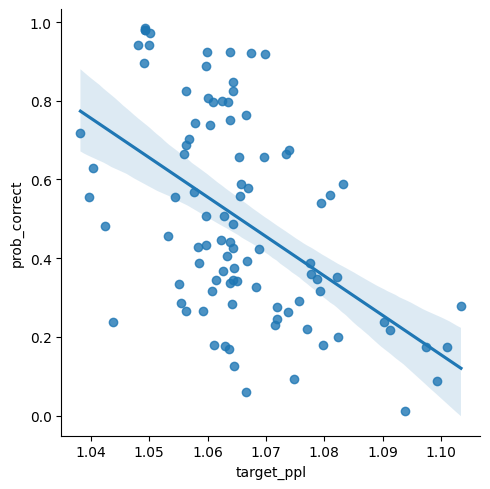

<Figure size 640x480 with 0 Axes>

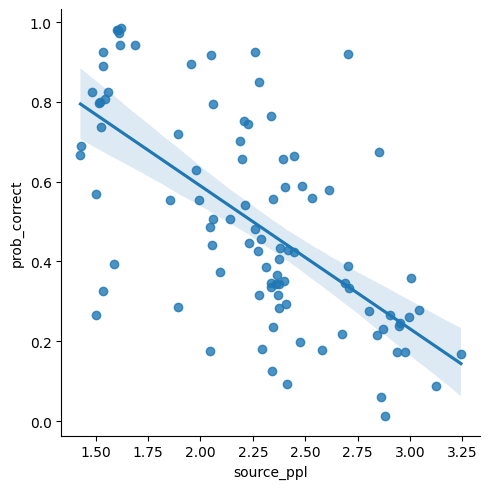

<Figure size 640x480 with 0 Axes>

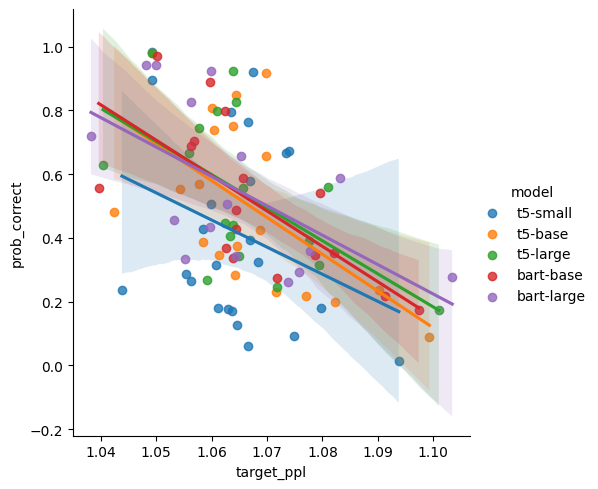

<Figure size 640x480 with 0 Axes>

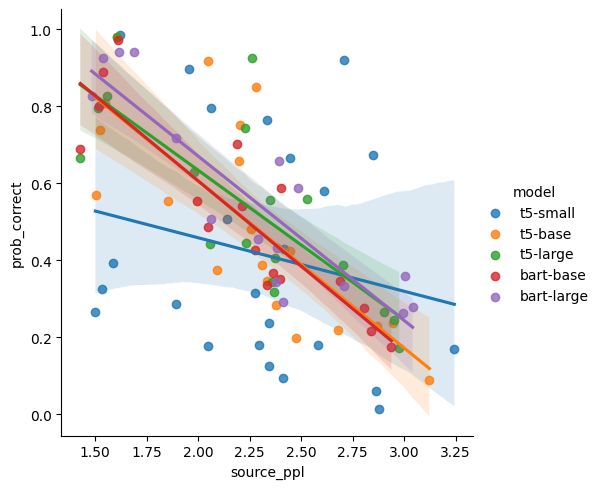

In [13]:

from scipy import stats

target_slope, target_intercept, target_r_value, target_p_value, target_std_err = stats.linregress(calflow_all_dfs['target_ppl'], calflow_all_dfs['prob_correct'])
print(f"target_p_value: {target_p_value}")
sns.lmplot(data=calflow_all_dfs, x='target_ppl', y='prob_correct', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(target_slope,target_intercept)})
plt.figure()
source_slope, source_intercept, source_r_value, source_p_value, source_std_err = stats.linregress(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_correct'])
print(f"source_p_value: {source_p_value}")
sns.lmplot(data=calflow_all_dfs, x='source_ppl', y='prob_correct', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(source_slope,source_intercept)})
plt.figure()

for model in calflow_all_dfs['model'].unique():
    df = calflow_all_dfs[calflow_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['target_ppl'], df['prob_correct'])
    print(f"{model} target_p_value: {p_value}")
#     sns.lmplot(data= df, x='target_ppl', y='prob_correct', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
#     plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure()
for model in calflow_all_dfs['model'].unique():
    df = calflow_all_dfs[calflow_all_dfs['model'] == model]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['source_ppl'], df['prob_correct'])
    print(f"{model} source_p_value: {p_value}")
#     sns.lmplot(data= df, x='source_ppl', y='prob_correct', scatter=True, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
#     plt.title(f"{model} p_value: {p_value:.3f}")
# plt.figure() 

sns.lmplot(data=calflow_all_dfs, x='target_ppl', y='prob_correct', scatter=True, hue="model")
plt.figure()
sns.lmplot(data=calflow_all_dfs, x='source_ppl', y='prob_correct', scatter=True, hue="model")

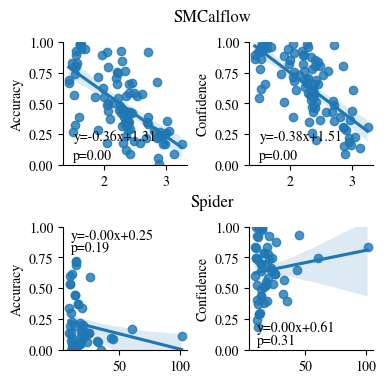

In [42]:
from matplotlib import pyplot as plt 

plt.rcParams["font.family"] = "Nimbus Roman"

def get_reg_data(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope, intercept, p_value
# make plot for paper 
# don't plot ECE for now 
# fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw = dict(wspace=0.5, hspace=0.5))
fig, axs = plt.subplots(2, 2, figsize=(4, 4), sharex=False, sharey=False, gridspec_kw = dict(wspace=0.5, hspace=0.5))


# fill data 
# sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "bin_ece", ax = axs[0,0])
sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "prob_correct", ax = axs[0,0])
sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "prob_model", ax = axs[0,1])
# add slopes, intercepts, p-values as text 
# ece_slope, ece_intercept, ece_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['bin_ece'])
acc_slope, acc_intercept, acc_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_correct'])
conf_slope, conf_intercept, conf_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_model'])

# axs[0,0].text(1.5, 0.1, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
# axs[0,0].text(1.5, 0.05, f"p={ece_p_value:.2f}")

axs[0,0].text(1.5, 0.20, f"y={acc_slope:.2f}x+{acc_intercept:.2f}")
axs[0,0].text(1.5, 0.05, f"p={acc_p_value:.2f}")

axs[0,1].text(1.5, 0.20, f"y={conf_slope:.2f}x+{conf_intercept:.2f}")
axs[0,1].text(1.5, 0.05, f"p={conf_p_value:.2f}")

# plot spider 
# sns.regplot(data = spider_all_dfs, x = "source_ppl", y = "bin_ece", ax = axs[1,0])
sns.regplot(data = spider_all_dfs, x = "source_ppl", y = "prob_correct", ax = axs[1,0])
sns.regplot(data = spider_all_dfs, x = "source_ppl", y = "prob_model", ax = axs[1,1])
# ece_slope, ece_intercept, ece_p_value = get_reg_data(spider_all_dfs['source_ppl'], spider_all_dfs['bin_ece'])
acc_slope, acc_intercept, acc_p_value = get_reg_data(spider_all_dfs['source_ppl'], spider_all_dfs['prob_correct'])
conf_slope, conf_intercept, conf_p_value = get_reg_data(spider_all_dfs['source_ppl'], spider_all_dfs['prob_model'])

# axs[1,0].text(1.5, 0.4, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
# axs[1,0].text(1.5, 0.25, f"p={ece_p_value:.2f}")

axs[1,0].text(10, 0.9, f"y={acc_slope:.2f}x+{acc_intercept:.2f}")
axs[1,0].text(10, 0.8, f"p={acc_p_value:.2f}")

axs[1,1].text(10, 0.15, f"y={conf_slope:.2f}x+{conf_intercept:.2f}")
axs[1,1].text(10, 0.05, f"p={conf_p_value:.2f}")

for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel("")
        
# first row is SMCalflow
axs[0,0].set_title("SMCalflow", x=1.2, y=1.1)
# second row is Spider
axs[1,0].set_title("Spider", x=1.2, y=1.1)
# first column is Calibration error
# axs[0,0].set_ylabel("Calibration error")
# axs[1,0].set_ylabel("Calibration error")
# second column is Accuracy
axs[0,0].set_ylabel("Accuracy") 
axs[1,0].set_ylabel("Accuracy")
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,1)
# third column is confidence
axs[0,1].set_ylabel("Confidence")
axs[1,1].set_ylabel("Confidence")
axs[0,1].set_ylim(0,1)
axs[1,1].set_ylim(0,1)
sns.despine()

plt.savefig("/home/estengel/papers/calibration-parsing-2023/figures/calflow_vs_spider_ppl.pdf", bbox_inches='tight')

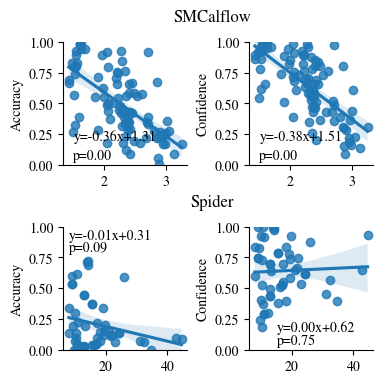

In [47]:
## What if we get rid of the two outlier bins 


fig, axs = plt.subplots(2, 2, figsize=(4, 4), sharex=False, sharey=False, gridspec_kw = dict(wspace=0.5, hspace=0.5))


# spider_df_no_outlier = spider_all_dfs[spider_all_dfs['source_ppl'] < 100]
spider_df_no_outlier = spider_all_dfs[spider_all_dfs['source_ppl'] < 50]

# fill data 
# sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "bin_ece", ax = axs[0,0])
sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "prob_correct", ax = axs[0,0])
sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "prob_model", ax = axs[0,1])
# add slopes, intercepts, p-values as text 
# ece_slope, ece_intercept, ece_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['bin_ece'])
acc_slope, acc_intercept, acc_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_correct'])
conf_slope, conf_intercept, conf_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_model'])

# axs[0,0].text(1.05, 0.1, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
# axs[0,0].text(1.05, 0.05, f"p={ece_p_value:.2f}")

axs[0,0].text(1.5, 0.20, f"y={acc_slope:.2f}x+{acc_intercept:.2f}")
axs[0,0].text(1.5, 0.05, f"p={acc_p_value:.2f}")

axs[0,1].text(1.5, 0.20, f"y={conf_slope:.2f}x+{conf_intercept:.2f}")
axs[0,1].text(1.5, 0.05, f"p={conf_p_value:.2f}")

# plot spider 
# sns.regplot(data = spider_all_dfs, x = "source_ppl", y = "bin_ece", ax = axs[1,0])
sns.regplot(data = spider_df_no_outlier, x = "source_ppl", y = "prob_correct", ax = axs[1,0])
sns.regplot(data = spider_df_no_outlier, x = "source_ppl", y = "prob_model", ax = axs[1,1])
# ece_slope, ece_intercept, ece_p_value = get_reg_data(spider_all_dfs['source_ppl'], spider_all_dfs['bin_ece'])
acc_slope, acc_intercept, acc_p_value = get_reg_data(spider_df_no_outlier['source_ppl'], spider_df_no_outlier['prob_correct'])
conf_slope, conf_intercept, conf_p_value = get_reg_data(spider_df_no_outlier['source_ppl'], spider_df_no_outlier['prob_model'])

# axs[1,0].text(1.5, 0.4, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
# axs[1,0].text(1.5, 0.25, f"p={ece_p_value:.2f}")

axs[1,0].text(8.2, 0.9, f"y={acc_slope:.2f}x+{acc_intercept:.2f}")
axs[1,0].text(8.2, 0.8, f"p={acc_p_value:.2f}")

axs[1,1].text(15.2, 0.15, f"y={conf_slope:.2f}x+{conf_intercept:.2f}")
axs[1,1].text(15.2, 0.05, f"p={conf_p_value:.2f}")

for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel("")
        
# first row is SMCalflow
axs[0,0].set_title("SMCalflow", x=1.2, y=1.1)
# second row is Spider
axs[1,0].set_title("Spider", x=1.2, y=1.1)

# # first column is Calibration error
# axs[0,0].set_ylabel("Calibration error")
# axs[1,0].set_ylabel("Calibration error")
# second column is Accuracy
axs[0,0].set_ylabel("Accuracy") 
axs[1,0].set_ylabel("Accuracy")
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,1)
# third column is confidence
axs[0,1].set_ylabel("Confidence")
axs[1,1].set_ylabel("Confidence")
axs[0,1].set_ylim(0,1)
axs[1,1].set_ylim(0,1)
sns.despine()

plt.savefig("/home/estengel/papers/calibration-parsing-2023/figures/calflow_vs_spider_ppl_no_outlier.pdf", bbox_inches='tight')

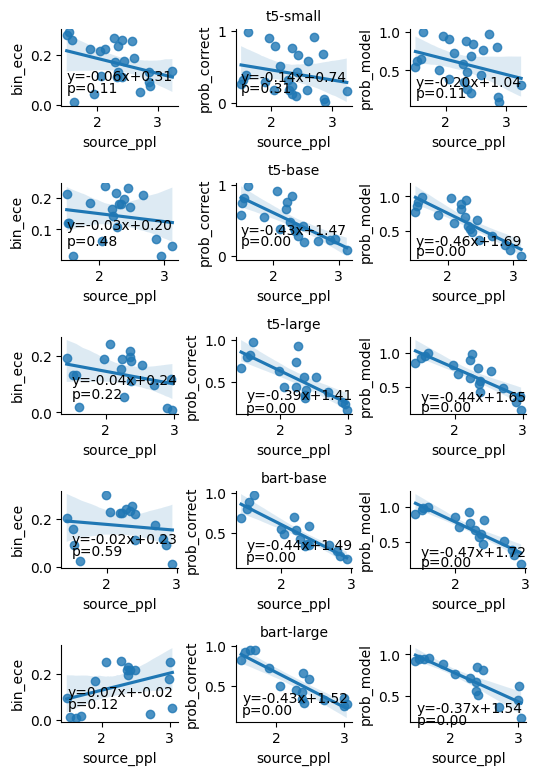

In [17]:
# smcalflow plot each one separately

fig, axs = plt.subplots(5, 3, figsize=(6, 9), sharex=False, sharey=False, gridspec_kw = dict(wspace=0.5, hspace=1.0))



# fill data 

for i, model in enumerate(['t5-small','t5-base','t5-large','bart-base','bart-large']):

    subset_df = calflow_all_dfs[calflow_all_dfs['model'] == model]
    sns.regplot(data = subset_df, x = "source_ppl", y = "bin_ece", ax = axs[i,0])
    sns.regplot(data = subset_df, x = "source_ppl", y = "prob_correct", ax = axs[i,1])
    sns.regplot(data = subset_df, x = "source_ppl", y = "prob_model", ax = axs[i,2])
    # add slopes, intercepts, p-values as text 
    ece_slope, ece_intercept, ece_p_value = get_reg_data(subset_df['source_ppl'], subset_df['bin_ece'])
    acc_slope, acc_intercept, acc_p_value = get_reg_data(subset_df['source_ppl'], subset_df['prob_correct'])
    conf_slope, conf_intercept, conf_p_value = get_reg_data(subset_df['source_ppl'], subset_df['prob_model'])

    axs[i,1].set_title(model, fontsize=10)
    axs[i,0].text(1.5, 0.1, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
    axs[i,0].text(1.5, 0.05, f"p={ece_p_value:.2f}")

    axs[i,1].text(1.5, 0.3, f"y={acc_slope:.2f}x+{acc_intercept:.2f}")
    axs[i,1].text(1.5, 0.15, f"p={acc_p_value:.2f}")

    axs[i,2].text(1.5, 0.3, f"y={conf_slope:.2f}x+{conf_intercept:.2f}")
    axs[i,2].text(1.5, 0.15, f"p={conf_p_value:.2f}")

sns.despine()
